In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from IPython.display import Latex

from sklearn import tree
import matplotlib.pyplot as plt 
from sklearn.tree import plot_tree
from sklearn.tree.export import export_text
import sklearn

In [2]:
dat = pd.read_csv('西瓜数据集3.0.csv')

In [3]:
dat.columns = ["num","color","root","voice","vein","umbilical","touch","density","sugar","isgood"]

In [4]:
dat

,num,color,root,voice,vein,umbilical,touch,density,sugar,isgood
0,1,青绿,蜷缩,浊响,清晰,凹陷,硬滑,0.697,0.460,好瓜
1,2,乌黑,蜷缩,沉闷,清晰,凹陷,硬滑,0.744,0.376,好瓜
2,3,乌黑,蜷缩,浊响,清晰,凹陷,硬滑,0.634,0.264,好瓜
3,4,青绿,蜷缩,沉闷,清晰,凹陷,硬滑,0.608,0.318,好瓜
4,5,浅白,蜷缩,浊响,清晰,凹陷,硬滑,0.556,0.215,好瓜
5,6,青绿,稍蜷,浊响,清晰,稍凹,软粘,0.403,0.237,好瓜
6,7,乌黑,稍蜷,浊响,稍糊,稍凹,软粘,0.481,0.149,好瓜
7,8,乌黑,稍蜷,浊响,清晰,稍凹,硬滑,0.437,0.211,好瓜
8,9,乌黑,稍蜷,沉闷,稍糊,稍凹,硬滑,0.666,0.091,坏瓜
9,10,青绿,硬挺,清脆,清晰,平坦,软粘,0.243,0.267,坏瓜


In [5]:
Latex(r"$Ent(D) = - \sum_{k = 1}^{|Y|}p_k log_2p_k$")

<IPython.core.display.Latex object>

In [6]:
Latex(r"$Gain(D,a) = Ent(D) - \sum_{v = 1}^{V}\frac{|D^v|}{|D|}Ent(D^v)$")

<IPython.core.display.Latex object>

In [7]:
Latex(r"$Gain\_ratio(D,a) = \frac{Gain(D,a)}{Ent(a)}$")

<IPython.core.display.Latex object>

# 1.1 定义信息准则（信息熵、信息增益、信息增益率以及基尼系数）

In [8]:
## 信息熵
def entropy(Xv):
    cnt = pd.Series(Counter(Xv))
    return -np.sum((cnt/cnt.sum()) * np.log2(cnt/cnt.sum()))

## 信息增益(属性Xvar)
def Info_gain(xVar,data = dat,target = 'isgood'):
    init_val = 0
    for item in data[xVar].unique():
        init_val += entropy(data[data[xVar] == item][target])*(data[data[xVar] == item].shape[0]/data.shape[0])
    return entropy(data[target]) - init_val

## 信息增益率
def Gain_ratio(xVar,data = dat,target = 'isgood'):
    return Info_gain(xVar,data = data,target = target)/entropy(data[xVar])

def gini(Xv):
    cnt = pd.Series(Counter(Xv))
    return 1 - np.sum((cnt/cnt.sum())*(cnt/cnt.sum()))

## 基尼系数
def gini_index(xVar,data = dat,target = 'isgood'):
    init_val = 0
    for item in data[xVar].unique():
        init_val += gini(data[data[xVar]==item][target])*(data[data[xVar] == item].shape[0]/data.shape[0])
    return init_val

# 2.1 连续值的处理

In [9]:
def continuous_gain(xVar,data = dat,target = 'isgood'):
    '''
    data: source数据源
    target:定义目标变量
    xVar:计算相关变量的信息增益值，其类型为连续性数值变量
    其背后逻辑详见：周志华《机器学习》P84
    '''
    sorta = data[xVar].sort_values()
    Ta = (sorta.shift(-1)+sorta)/2
    res = 0
    resA = None
    for t in Ta:
        data['nw'] = '大于临界值'
        data.loc[data[xVar] < t,'nw'] = '小于临界值'
        gain = Info_gain(xVar = 'nw',data = data,target = target)
        if res < gain:
            res = gain
            resA = t
    return res,resA

In [10]:
for item in ['density', 'sugar']:
    gain = continuous_gain(xVar = item)
    print('%s 信息增益是:%1.3f,其切分点为：%8.3f'%(item,gain[0],gain[1]))

density 信息增益是:0.262,其切分点为：   0.381
sugar 信息增益是:0.349,其切分点为：   0.126


# 3.1 基于信息增益准则，生成一棵决策树

In [11]:
for item in ['color', 'root', 'voice', 'vein', 'umbilical', 'touch','density', 'sugar']:
    if item not in ['density', 'sugar']:
        gain = Info_gain(xVar = item)
        gain_ratio = Gain_ratio(xVar = item)
        gini_idx = gini_index(xVar = item)
        print('%s 信息增益是:%1.3f,信息增益率是:%1.3f,基尼系数是:%1.3f'%(item,gain,gain_ratio,gini_idx))
    else:
        gain = continuous_gain(xVar = item)
        print('%s 信息增益是:%1.3f,其切分点为：%8.3f'%(item,gain[0],gain[1]))

color 信息增益是:0.108,信息增益率是:0.068,基尼系数是:0.427
root 信息增益是:0.143,信息增益率是:0.102,基尼系数是:0.422
voice 信息增益是:0.141,信息增益率是:0.106,基尼系数是:0.424
vein 信息增益是:0.381,信息增益率是:0.263,基尼系数是:0.277
umbilical 信息增益是:0.289,信息增益率是:0.187,基尼系数是:0.345
touch 信息增益是:0.006,信息增益率是:0.007,基尼系数是:0.494
density 信息增益是:0.262,其切分点为：   0.381
sugar 信息增益是:0.349,其切分点为：   0.126


In [12]:
def genvar(x,critical = 0.381):
    if x < critical:
        return '低于'+ str(critical)
    else:
        return '高于'+ str(critical)

In [13]:
dat['new_density'] = [genvar(x,critical = 0.381) for x in dat.density]
dat['new_sugar'] = [genvar(x,critical = 0.126) for x in dat.sugar]

In [14]:
for item in ['color', 'root', 'voice', 'umbilical', 'touch','density', 'sugar','new_density','new_sugar']:
    if item not in ['density', 'sugar']:
        gain = Info_gain(xVar = item,data = dat[dat.vein =='清晰'])
        gain_ratio = Gain_ratio(xVar = item,data = dat[dat.vein =='清晰'])
        gini_idx = gini_index(xVar = item,data = dat[dat.vein =='清晰'])
        print('%s 信息增益是:%1.3f,信息增益率是:%1.3f,基尼系数是:%1.3f'%(item,gain,gain_ratio,gini_idx))

color 信息增益是:0.043,信息增益率是:0.031,基尼系数是:0.333
root 信息增益是:0.458,信息增益率是:0.339,基尼系数是:0.148
voice 信息增益是:0.331,信息增益率是:0.270,基尼系数是:0.185
umbilical 信息增益是:0.458,信息增益率是:0.339,基尼系数是:0.148
touch 信息增益是:0.458,信息增益率是:0.499,基尼系数是:0.148
new_density 信息增益是:0.764,信息增益率是:1.000,基尼系数是:0.000
new_sugar 信息增益是:0.000,信息增益率是:nan,基尼系数是:0.346


C:\Users\ququxi\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


In [12]:
dat

,num,color,root,voice,vein,umbilical,touch,density,sugar,isgood,nw,new_density,new_sugar
0,1,青绿,蜷缩,浊响,清晰,凹陷,硬滑,0.697,0.460,好瓜,大于临界值,高于0.381,高于0.126
1,2,乌黑,蜷缩,沉闷,清晰,凹陷,硬滑,0.744,0.376,好瓜,大于临界值,高于0.381,高于0.126
2,3,乌黑,蜷缩,浊响,清晰,凹陷,硬滑,0.634,0.264,好瓜,大于临界值,高于0.381,高于0.126
3,4,青绿,蜷缩,沉闷,清晰,凹陷,硬滑,0.608,0.318,好瓜,大于临界值,高于0.381,高于0.126
4,5,浅白,蜷缩,浊响,清晰,凹陷,硬滑,0.556,0.215,好瓜,大于临界值,高于0.381,高于0.126
5,6,青绿,稍蜷,浊响,清晰,稍凹,软粘,0.403,0.237,好瓜,大于临界值,高于0.381,高于0.126
6,7,乌黑,稍蜷,浊响,稍糊,稍凹,软粘,0.481,0.149,好瓜,大于临界值,高于0.381,高于0.126
7,8,乌黑,稍蜷,浊响,清晰,稍凹,硬滑,0.437,0.211,好瓜,大于临界值,高于0.381,高于0.126
8,9,乌黑,稍蜷,沉闷,稍糊,稍凹,硬滑,0.666,0.091,坏瓜,大于临界值,高于0.381,低于0.126
9,10,青绿,硬挺,清脆,清晰,平坦,软粘,0.243,0.267,坏瓜,大于临界值,低于0.381,高于0.126


# 利用sklearn模块

In [13]:
X = dat.drop(['num','nw','density','sugar'],axis=1)
y = dat.isgood                                          #提取特征与目标

In [14]:
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
d = defaultdict(LabelEncoder)
X_trans = X.apply(lambda x: d[x.name].fit_transform(x))
X_trans            #映射特征字段，将字符映射为数值；都是单一类型直接映射

,color,root,voice,vein,umbilical,touch,isgood,new_density,new_sugar
0,2,2,1,1,0,0,1,1,1
1,0,2,0,1,0,0,1,1,1
2,0,2,1,1,0,0,1,1,1
3,2,2,0,1,0,0,1,1,1
4,1,2,1,1,0,0,1,1,1
5,2,1,1,1,2,1,1,1,1
6,0,1,1,2,2,1,1,1,1
7,0,1,1,1,2,0,1,1,1
8,0,1,0,2,2,0,0,1,0
9,2,0,2,1,1,1,0,0,1


In [20]:
help(tree.DecisionTreeClassifier)

Help on class DecisionTreeClassifier in module sklearn.tree.tree:

class DecisionTreeClassifier(BaseDecisionTree, sklearn.base.ClassifierMixin)
 |  DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, presort=False)
 |  
 |  A decision tree classifier.
 |  
 |  Read more in the :ref:`User Guide <tree>`.
 |  
 |  Parameters
 |  ----------
 |  criterion : string, optional (default="gini")
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "entropy" for the information gain.
 |  
 |  splitter : string, optional (default="best")
 |      The strategy used to choose the split at each node. Supported
 |      strategies are "best" to choose the best split and "random" to choose
 |      the best random split.

In [24]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=10,criterion='entropy',min_samples_split=5)
clf = clf.fit(X_trans.drop(['isgood','new_sugar','new_density'],axis = 1), y)          #调用机器学习包 决策树模型
r = export_text(clf, feature_names=X_trans.drop(['isgood','new_sugar','new_density'],axis = 1).columns.tolist())
print(r)

|--- vein <= 0.50
|   |--- class: 坏瓜
|--- vein >  0.50
|   |--- vein <= 1.50
|   |   |--- touch <= 0.50
|   |   |   |--- class: 好瓜
|   |   |--- touch >  0.50
|   |   |   |--- class: 坏瓜
|   |--- vein >  1.50
|   |   |--- touch <= 0.50
|   |   |   |--- class: 坏瓜
|   |   |--- touch >  0.50
|   |   |   |--- class: 好瓜



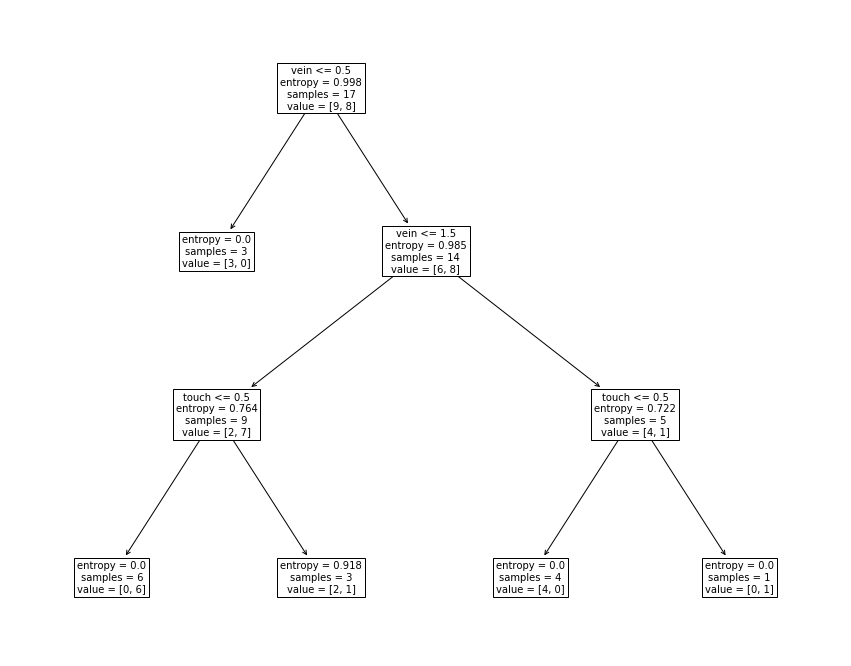

In [25]:
import matplotlib as plt
plt.rcParams['figure.figsize'] = (15.0, 12.0)
t = plot_tree(clf,feature_names=X_trans.drop(['isgood','new_sugar','new_density'],axis = 1).columns.tolist(), fontsize=10)

### 上文选择含糖率作为一个节点：划分标准应为结合信息增益与信息增益率，首先从候选说出去属性中找出信息增益高出平均水平的属性，然后再从中选择增益率最高的。

In [48]:
for item in ['color', 'root', 'voice', 'umbilical', 'touch','density', 'sugar','new_density','new_sugar']:
    if item not in ['density', 'sugar']:
        gain = Info_gain(xVar = item,data = dat)
        gain_ratio = Gain_ratio(xVar = item,data = dat)
        gini_idx = gini_index(xVar = item,data = dat)
        print('%s 信息增益是:%1.3f,信息增益率是:%1.3f,基尼系数是:%1.3f'%(item,gain,gain_ratio,gini_idx))

color 信息增益是:0.108,信息增益率是:0.068,基尼系数是:0.427
root 信息增益是:0.143,信息增益率是:0.102,基尼系数是:0.422
voice 信息增益是:0.141,信息增益率是:0.106,基尼系数是:0.424
umbilical 信息增益是:0.289,信息增益率是:0.187,基尼系数是:0.345
touch 信息增益是:0.006,信息增益率是:0.007,基尼系数是:0.494
new_density 信息增益是:0.262,信息增益率是:0.333,基尼系数是:0.362
new_sugar 信息增益是:0.349,信息增益率是:0.400,基尼系数是:0.314


In [51]:
for item in ['color', 'root', 'voice', 'vein','umbilical', 'touch','density', 'sugar','new_density','new_sugar']:
    if item not in ['density', 'sugar']:
        gain = Info_gain(xVar = item,data = X_trans)
        gain_ratio = Gain_ratio(xVar = item,data = X_trans)
        gini_idx = gini_index(xVar = item,data = X_trans)
        print('%s 信息增益是:%1.3f,信息增益率是:%1.3f,基尼系数是:%1.3f'%(item,gain,gain_ratio,gini_idx))

color 信息增益是:0.108,信息增益率是:0.068,基尼系数是:0.427
root 信息增益是:0.143,信息增益率是:0.102,基尼系数是:0.422
voice 信息增益是:0.141,信息增益率是:0.106,基尼系数是:0.424
vein 信息增益是:0.381,信息增益率是:0.263,基尼系数是:0.277
umbilical 信息增益是:0.289,信息增益率是:0.187,基尼系数是:0.345
touch 信息增益是:0.006,信息增益率是:0.007,基尼系数是:0.494
new_density 信息增益是:0.262,信息增益率是:0.333,基尼系数是:0.362
new_sugar 信息增益是:0.349,信息增益率是:0.400,基尼系数是:0.314
